In [1]:
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

In [2]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
registry = pd.read_csv("~/Box/dsi-core/11th-hour/idi-corporate-structure/20250630-0800-gleif-goldencopy-lei2-golden-copy.csv", low_memory=False)

In [4]:
relationships = pd.read_csv("~/Box/dsi-core/11th-hour/idi-corporate-structure/20250630-0800-gleif-goldencopy-rr-golden-copy.csv", low_memory=False)

In [5]:
relationships[
    relationships["Relationship.StartNode.NodeID"] == relationships["Relationship.EndNode.NodeID"]
]["Relationship.RelationshipType"].value_counts()

Relationship.RelationshipType
IS_FUND-MANAGED_BY               2726
IS_SUBFUND_OF                       5
IS_INTERNATIONAL_BRANCH_OF          5
IS_DIRECTLY_CONSOLIDATED_BY         4
IS_ULTIMATELY_CONSOLIDATED_BY       4
IS_FEEDER_TO                        1
Name: count, dtype: int64

In [6]:
nontrivial_relationships = relationships[relationships["Relationship.StartNode.NodeID"] != relationships["Relationship.EndNode.NodeID"]]

In [7]:
len(relationships), len(nontrivial_relationships)

(457666, 454921)

In [8]:
G = nx.DiGraph()
G.add_edges_from(zip(
    nontrivial_relationships["Relationship.StartNode.NodeID"], nontrivial_relationships["Relationship.EndNode.NodeID"]
))

In [9]:
for lei1, lei2 in nx.simple_cycles(G):
    for _, row in nontrivial_relationships[
        (nontrivial_relationships["Relationship.StartNode.NodeID"] == lei1) & (nontrivial_relationships["Relationship.EndNode.NodeID"] == lei2)
    ].iterrows():
        print(
            "|", row["Relationship.StartNode.NodeID"], "|",
            row["Relationship.EndNode.NodeID"], "|",
            registry[registry["LEI"] == lei1].iloc[0]["Entity.LegalName"], "|",
            row["Relationship.RelationshipType"], "|",
            registry[registry["LEI"] == lei2].iloc[0]["Entity.LegalName"], "|",
        )
    for _, row in nontrivial_relationships[
        (nontrivial_relationships["Relationship.StartNode.NodeID"] == lei2) & (nontrivial_relationships["Relationship.EndNode.NodeID"] == lei1)
    ].iterrows():
        print(
            "|", row["Relationship.StartNode.NodeID"], "|",
            row["Relationship.EndNode.NodeID"], "|",
            registry[registry["LEI"] == lei2].iloc[0]["Entity.LegalName"], "|",
            row["Relationship.RelationshipType"], "|",
            registry[registry["LEI"] == lei1].iloc[0]["Entity.LegalName"], "|",
        )
    print()

| 875500TZ1L5V7UD5AK87 | 967600PB5R0OK1RIP462 | Spinecap Feeder Fund SCA SICAV-RAIF | IS_FEEDER_TO | SPINECAP MASTER FUND SCSP |
| 967600PB5R0OK1RIP462 | 875500TZ1L5V7UD5AK87 | SPINECAP MASTER FUND SCSP | IS_DIRECTLY_CONSOLIDATED_BY | Spinecap Feeder Fund SCA SICAV-RAIF |
| 967600PB5R0OK1RIP462 | 875500TZ1L5V7UD5AK87 | SPINECAP MASTER FUND SCSP | IS_ULTIMATELY_CONSOLIDATED_BY | Spinecap Feeder Fund SCA SICAV-RAIF |

| 635400EORFCSCZIKSX86 | 635400CZY8QWLKJEDJ19 | Diversified and Balanced Joint Equity Fund 2022 | IS_SUBFUND_OF | World Strategies |
| 635400CZY8QWLKJEDJ19 | 635400EORFCSCZIKSX86 | World Strategies | IS_SUBFUND_OF | Diversified and Balanced Joint Equity Fund 2022 |

| 549300UL82SFGRH2N895 | 549300S22LJBRUV5NU38 | SDK GLOBAL OPPORTUNITY FUND, L.P. | IS_FUND-MANAGED_BY | SDK CAPITAL, LLC |
| 549300S22LJBRUV5NU38 | 549300UL82SFGRH2N895 | SDK CAPITAL, LLC | IS_DIRECTLY_CONSOLIDATED_BY | SDK GLOBAL OPPORTUNITY FUND, L.P. |
| 549300S22LJBRUV5NU38 | 549300UL82SFGRH2N895 | SDK CAPI

In [10]:
[x for x in registry.columns if "Country" in x]

['Entity.LegalAddress.Country',
 'Entity.HeadquartersAddress.Country',
 'Entity.OtherAddresses.OtherAddress.1.Country',
 'Entity.OtherAddresses.OtherAddress.2.Country',
 'Entity.OtherAddresses.OtherAddress.3.Country',
 'Entity.OtherAddresses.OtherAddress.4.Country',
 'Entity.OtherAddresses.OtherAddress.5.Country',
 'Entity.TransliteratedOtherAddresses.TransliteratedOtherAddress.1.Country',
 'Entity.TransliteratedOtherAddresses.TransliteratedOtherAddress.2.Country',
 'Entity.TransliteratedOtherAddresses.TransliteratedOtherAddress.3.Country',
 'Entity.TransliteratedOtherAddresses.TransliteratedOtherAddress.4.Country',
 'Entity.TransliteratedOtherAddresses.TransliteratedOtherAddress.5.Country']

In [11]:
# https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
world_countries = gpd.read_file("~/Downloads/ne_10m_admin_0_countries.zip")

In [12]:
def merge_small(x):
    return {"BQ": "NL", "CX": "AU", "GF": "FR", "GP": "FR", "MQ": "FR", "RE": "FR", "YT": "FR"}.get(x, x)

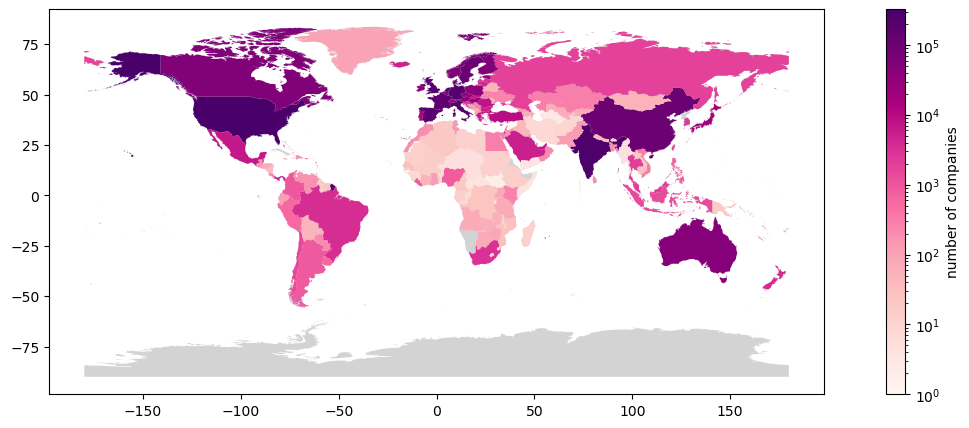

In [13]:
fig, ax = plt.subplots(figsize=(16, 5))

world_countries.plot(color="lightgray", ax=ax)

world_countries.merge(
    registry["Entity.LegalAddress.Country"].map(merge_small).value_counts().to_frame("num_companies").reset_index(),
    left_on="ISO_A2_EH",
    right_on="Entity.LegalAddress.Country",
).plot(column="num_companies", cmap="RdPu", norm=mpl.colors.LogNorm(), legend=True, legend_kwds={"label": "number of companies"}, ax=ax)

None

In [14]:
EntityCreationDate = registry["Entity.EntityCreationDate"].apply(
    lambda x: datetime.strptime(x[:10], "%Y-%m-%d").replace(tzinfo=timezone.utc) if isinstance(x, str) else pd.NaT
)
EntityCreationDate = pd.to_datetime(EntityCreationDate[
    (datetime.fromisoformat("1900-01-01T00:00:00").replace(tzinfo=timezone.utc) <= EntityCreationDate)
    & (EntityCreationDate < datetime.fromisoformat("2026-01-01T00:00:00").replace(tzinfo=timezone.utc))
])

In [15]:
InitialRegistrationDate = registry["Registration.InitialRegistrationDate"].apply(
    lambda x: datetime.strptime(x[:10], "%Y-%m-%d").replace(tzinfo=timezone.utc) if isinstance(x, str) else pd.NaT
)
InitialRegistrationDate = pd.to_datetime(InitialRegistrationDate[
    (datetime.fromisoformat("1900-01-01T00:00:00").replace(tzinfo=timezone.utc) <= InitialRegistrationDate)
    & (InitialRegistrationDate < datetime.fromisoformat("2026-01-01T00:00:00").replace(tzinfo=timezone.utc))
])

In [16]:
LastUpdateDate = registry["Registration.LastUpdateDate"].apply(
    lambda x: datetime.strptime(x[:10], "%Y-%m-%d").replace(tzinfo=timezone.utc) if isinstance(x, str) else pd.NaT
)
LastUpdateDate = pd.to_datetime(LastUpdateDate[
    (datetime.fromisoformat("1900-01-01T00:00:00").replace(tzinfo=timezone.utc) <= LastUpdateDate)
    & (LastUpdateDate < datetime.fromisoformat("2026-01-01T00:00:00").replace(tzinfo=timezone.utc))
])

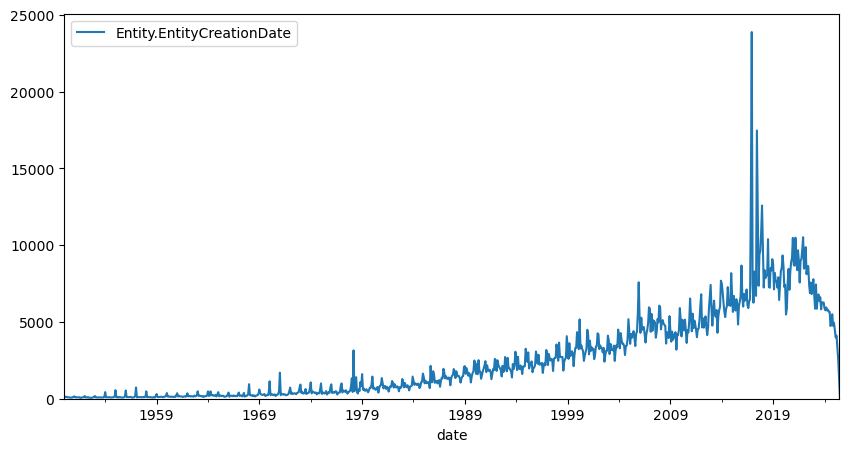

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

EntityCreationDate.to_frame("date").set_index("date").assign(count=1).resample("ME").sum().plot(legend=False, ax=ax)

ax.set_xlim(pd.to_datetime("1950-01-01"), pd.to_datetime("2025-06-01"))
ax.set_ylim(0, ax.get_ylim()[1])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Entity.EntityCreationDate"])

None

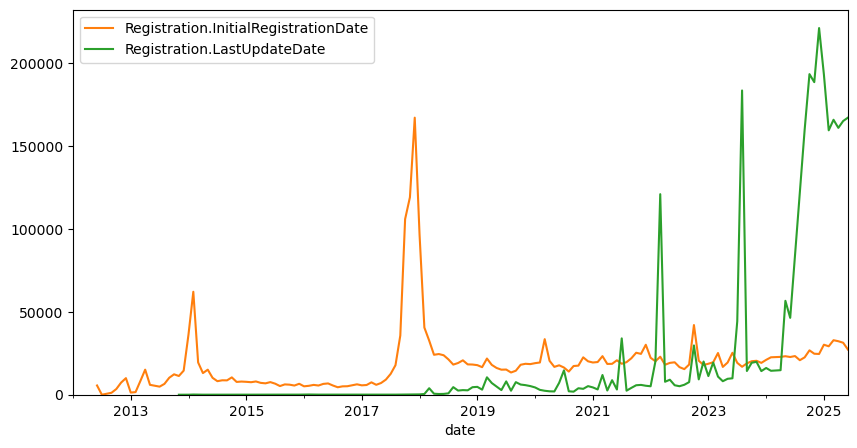

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))

InitialRegistrationDate.to_frame("date").set_index("date").assign(count=1).resample("ME").sum().plot(legend=False, color=default_colors[1], ax=ax)
LastUpdateDate.to_frame("date").set_index("date").assign(count=1).resample("ME").sum().plot(legend=False, color=default_colors[2], ax=ax)

ax.set_xlim(pd.to_datetime("2012-01-01"), pd.to_datetime("2025-06-01"))
ax.set_ylim(0, ax.get_ylim()[1])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Registration.InitialRegistrationDate", "Registration.LastUpdateDate"])

None

In [19]:
startDate = relationships["Relationship.Period.1.startDate"].apply(
    lambda x: datetime.strptime(x[:10], "%Y-%m-%d").replace(tzinfo=timezone.utc) if isinstance(x, str) else pd.NaT
)
startDate = pd.to_datetime(startDate[
    (datetime.fromisoformat("1900-01-01T00:00:00").replace(tzinfo=timezone.utc) <= startDate)
    & (startDate < datetime.fromisoformat("2026-01-01T00:00:00").replace(tzinfo=timezone.utc))
])

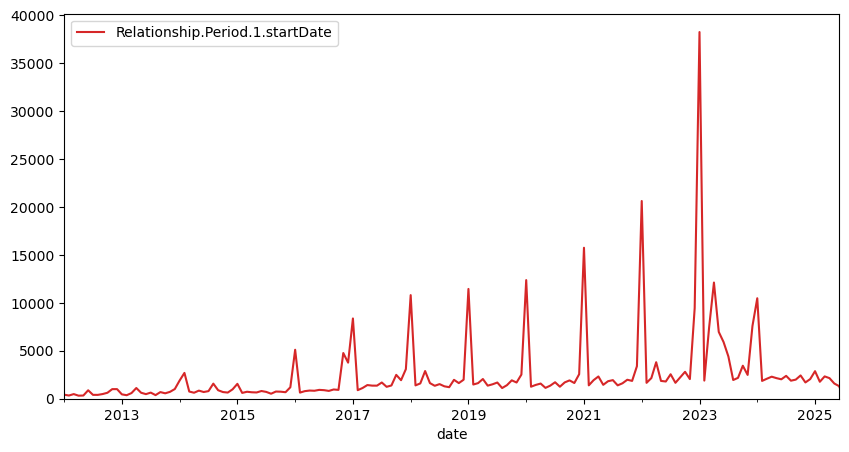

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

startDate.to_frame("date").set_index("date").assign(count=1).resample("ME").sum().plot(legend=False, color=default_colors[3], ax=ax)

ax.set_xlim(pd.to_datetime("2012-01-01"), pd.to_datetime("2025-06-01"))
ax.set_ylim(0, ax.get_ylim()[1])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Relationship.Period.1.startDate"])

None

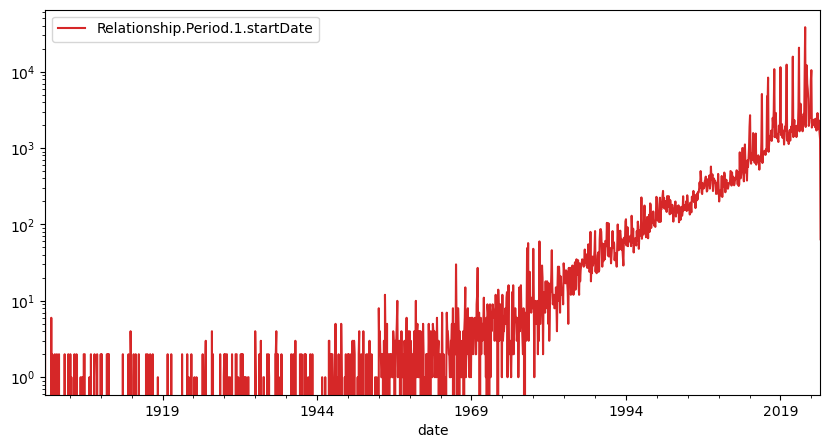

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

startDate.to_frame("date").set_index("date").assign(count=1).resample("ME").sum().plot(legend=False, color=default_colors[3], ax=ax)

ax.set_xlim(pd.to_datetime("1900-01-01"), pd.to_datetime("2025-06-01"))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Relationship.Period.1.startDate"])
ax.set_yscale("log")

None